# Build a Multi-output Model

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency).

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [3]:
# Specify data URI
URI = 'ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [4]:
norm_train_X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Unnamed: 10,Unnamed: 11
231,0.546085,-0.687656,-0.018962,-0.656309,0.995936,-0.470638,1.258751,-1.190075,NaN,NaN
618,-1.177803,1.278774,0.535455,0.975164,-1.002445,0.426790,-1.732534,-1.830484,NaN,NaN
531,0.929171,-0.968574,-0.573380,-0.656309,0.995936,1.324218,-0.984712,-0.549667,NaN,NaN
391,1.312257,-1.249492,-0.018962,-1.200134,0.995936,1.324218,0.137019,-0.549667,NaN,NaN
331,0.258770,-0.406737,0.535455,-0.656309,0.995936,1.324218,-0.984712,1.371559,NaN,NaN


In [5]:
norm_train_X = norm_train_X.drop(['Unnamed: 10', 'Unnamed: 11'], axis=1)
norm_test_X = norm_test_X.drop(['Unnamed: 10', 'Unnamed: 11'], axis=1)
norm_train_X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
231,0.546085,-0.687656,-0.018962,-0.656309,0.995936,-0.470638,1.258751,-1.190075
618,-1.177803,1.278774,0.535455,0.975164,-1.002445,0.426790,-1.732534,-1.830484
531,0.929171,-0.968574,-0.573380,-0.656309,0.995936,1.324218,-0.984712,-0.549667
391,1.312257,-1.249492,-0.018962,-1.200134,0.995936,1.324218,0.137019,-0.549667
331,0.258770,-0.406737,0.535455,-0.656309,0.995936,1.324218,-0.984712,1.371559


In [6]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,Unnamed: 10,Unnamed: 11
0,0.90,563.5,318.5,122.5,7.0,3,0.4,5,35.01,33.14,NaN,NaN
1,0.69,735.0,294.0,220.5,3.5,3,0.4,5,14.28,15.87,NaN,NaN
2,0.64,784.0,343.0,220.5,3.5,4,0.1,4,15.32,19.42,NaN,NaN
3,0.66,759.5,318.5,220.5,3.5,2,0.1,5,11.38,14.54,NaN,NaN
4,0.86,588.0,294.0,147.0,7.0,3,0.1,3,26.47,31.01,NaN,NaN


In [7]:
# Define model layers.
input_layer = Input(shape=(len(norm_train_X .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1152        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                              

In [8]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Train the Model

In [9]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 4ms/step - loss: 253.8612 - y1_output_loss: 119.2454 - y2_output_loss: 134.6158 - y1_output_root_mean_squared_error: 10.9200 - y2_output_root_mean_squared_error: 11.6024 - val_loss: 38.1312 - val_y1_output_loss: 17.4288 - val_y2_output_loss: 20.7024 - val_y1_output_root_mean_squared_error: 4.1748 - val_y2_output_root_mean_squared_error: 4.5500
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 34.7600 - y1_output_loss: 13.7478 - y2_output_loss: 21.0122 - y1_output_root_mean_squared_error: 3.7078 - y2_output_root_mean_squared_error: 4.5839 - val_loss: 73.5289 - val_y1_output_loss: 22.7003 - val_y2_output_loss: 50.8286 - val_y1_output_root_mean_squared_error: 4.7645 - val_y2_output_root_mean_squared_error: 7.1294
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 26.9303 - y1_output_loss: 11.3877 - y2_output_loss: 15.5426 - y1_output_root_mean_squared_error: 3.3746 - y2_output_root_mean_sq

Epoch 22/500
62/62 [==============================] - 0s 2ms/step - loss: 14.6651 - y1_output_loss: 5.6413 - y2_output_loss: 9.0238 - y1_output_root_mean_squared_error: 2.3751 - y2_output_root_mean_squared_error: 3.0040 - val_loss: 15.0898 - val_y1_output_loss: 5.8612 - val_y2_output_loss: 9.2286 - val_y1_output_root_mean_squared_error: 2.4210 - val_y2_output_root_mean_squared_error: 3.0379
Epoch 23/500
62/62 [==============================] - 0s 1ms/step - loss: 12.9601 - y1_output_loss: 5.1427 - y2_output_loss: 7.8174 - y1_output_root_mean_squared_error: 2.2677 - y2_output_root_mean_squared_error: 2.7960 - val_loss: 14.0159 - val_y1_output_loss: 5.7573 - val_y2_output_loss: 8.2587 - val_y1_output_root_mean_squared_error: 2.3994 - val_y2_output_root_mean_squared_error: 2.8738
Epoch 24/500
62/62 [==============================] - 0s 1ms/step - loss: 12.3356 - y1_output_loss: 4.9687 - y2_output_loss: 7.3669 - y1_output_root_mean_squared_error: 2.2291 - y2_output_root_mean_squared_error:

Epoch 43/500
62/62 [==============================] - 0s 2ms/step - loss: 7.8364 - y1_output_loss: 2.2431 - y2_output_loss: 5.5933 - y1_output_root_mean_squared_error: 1.4977 - y2_output_root_mean_squared_error: 2.3650 - val_loss: 7.4834 - val_y1_output_loss: 2.4368 - val_y2_output_loss: 5.0467 - val_y1_output_root_mean_squared_error: 1.5610 - val_y2_output_root_mean_squared_error: 2.2465
Epoch 44/500
62/62 [==============================] - 0s 2ms/step - loss: 7.3711 - y1_output_loss: 2.2387 - y2_output_loss: 5.1324 - y1_output_root_mean_squared_error: 1.4962 - y2_output_root_mean_squared_error: 2.2655 - val_loss: 9.2685 - val_y1_output_loss: 3.3334 - val_y2_output_loss: 5.9351 - val_y1_output_root_mean_squared_error: 1.8258 - val_y2_output_root_mean_squared_error: 2.4362
Epoch 45/500
62/62 [==============================] - 0s 2ms/step - loss: 6.5509 - y1_output_loss: 2.0947 - y2_output_loss: 4.4562 - y1_output_root_mean_squared_error: 1.4473 - y2_output_root_mean_squared_error: 2.11

Epoch 64/500
62/62 [==============================] - 0s 1ms/step - loss: 9.3357 - y1_output_loss: 2.5273 - y2_output_loss: 6.8083 - y1_output_root_mean_squared_error: 1.5898 - y2_output_root_mean_squared_error: 2.6093 - val_loss: 5.7098 - val_y1_output_loss: 1.8937 - val_y2_output_loss: 3.8161 - val_y1_output_root_mean_squared_error: 1.3761 - val_y2_output_root_mean_squared_error: 1.9535
Epoch 65/500
62/62 [==============================] - 0s 1ms/step - loss: 5.4286 - y1_output_loss: 1.5593 - y2_output_loss: 3.8693 - y1_output_root_mean_squared_error: 1.2487 - y2_output_root_mean_squared_error: 1.9671 - val_loss: 7.3229 - val_y1_output_loss: 2.6906 - val_y2_output_loss: 4.6323 - val_y1_output_root_mean_squared_error: 1.6403 - val_y2_output_root_mean_squared_error: 2.1523
Epoch 66/500
62/62 [==============================] - 0s 1ms/step - loss: 5.0417 - y1_output_loss: 1.5622 - y2_output_loss: 3.4794 - y1_output_root_mean_squared_error: 1.2499 - y2_output_root_mean_squared_error: 1.86

Epoch 85/500
62/62 [==============================] - 0s 2ms/step - loss: 3.2052 - y1_output_loss: 0.8750 - y2_output_loss: 2.3303 - y1_output_root_mean_squared_error: 0.9354 - y2_output_root_mean_squared_error: 1.5265 - val_loss: 3.8191 - val_y1_output_loss: 1.1176 - val_y2_output_loss: 2.7014 - val_y1_output_root_mean_squared_error: 1.0572 - val_y2_output_root_mean_squared_error: 1.6436
Epoch 86/500
62/62 [==============================] - 0s 2ms/step - loss: 3.5576 - y1_output_loss: 0.9451 - y2_output_loss: 2.6125 - y1_output_root_mean_squared_error: 0.9722 - y2_output_root_mean_squared_error: 1.6163 - val_loss: 3.7771 - val_y1_output_loss: 1.1485 - val_y2_output_loss: 2.6285 - val_y1_output_root_mean_squared_error: 1.0717 - val_y2_output_root_mean_squared_error: 1.6213
Epoch 87/500
62/62 [==============================] - 0s 2ms/step - loss: 8.1066 - y1_output_loss: 2.6201 - y2_output_loss: 5.4865 - y1_output_root_mean_squared_error: 1.6187 - y2_output_root_mean_squared_error: 2.34

Epoch 106/500
62/62 [==============================] - 0s 2ms/step - loss: 2.5578 - y1_output_loss: 0.5752 - y2_output_loss: 1.9826 - y1_output_root_mean_squared_error: 0.7584 - y2_output_root_mean_squared_error: 1.4080 - val_loss: 2.9820 - val_y1_output_loss: 0.8100 - val_y2_output_loss: 2.1719 - val_y1_output_root_mean_squared_error: 0.9000 - val_y2_output_root_mean_squared_error: 1.4738
Epoch 107/500
62/62 [==============================] - 0s 2ms/step - loss: 2.6560 - y1_output_loss: 0.6242 - y2_output_loss: 2.0318 - y1_output_root_mean_squared_error: 0.7901 - y2_output_root_mean_squared_error: 1.4254 - val_loss: 28.9335 - val_y1_output_loss: 2.9964 - val_y2_output_loss: 25.9371 - val_y1_output_root_mean_squared_error: 1.7310 - val_y2_output_root_mean_squared_error: 5.0928
Epoch 108/500
62/62 [==============================] - 0s 2ms/step - loss: 3.5656 - y1_output_loss: 0.8747 - y2_output_loss: 2.6909 - y1_output_root_mean_squared_error: 0.9353 - y2_output_root_mean_squared_error:

Epoch 127/500
62/62 [==============================] - 0s 1ms/step - loss: 3.3425 - y1_output_loss: 0.8496 - y2_output_loss: 2.4929 - y1_output_root_mean_squared_error: 0.9217 - y2_output_root_mean_squared_error: 1.5789 - val_loss: 4.3091 - val_y1_output_loss: 0.4707 - val_y2_output_loss: 3.8384 - val_y1_output_root_mean_squared_error: 0.6861 - val_y2_output_root_mean_squared_error: 1.9592
Epoch 128/500
62/62 [==============================] - 0s 1ms/step - loss: 1.9794 - y1_output_loss: 0.4331 - y2_output_loss: 1.5463 - y1_output_root_mean_squared_error: 0.6581 - y2_output_root_mean_squared_error: 1.2435 - val_loss: 3.2249 - val_y1_output_loss: 1.0355 - val_y2_output_loss: 2.1894 - val_y1_output_root_mean_squared_error: 1.0176 - val_y2_output_root_mean_squared_error: 1.4797
Epoch 129/500
62/62 [==============================] - 0s 1ms/step - loss: 2.4157 - y1_output_loss: 0.7122 - y2_output_loss: 1.7035 - y1_output_root_mean_squared_error: 0.8439 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 2ms/step - loss: 1.3925 - y1_output_loss: 0.2908 - y2_output_loss: 1.1018 - y1_output_root_mean_squared_error: 0.5392 - y2_output_root_mean_squared_error: 1.0496 - val_loss: 14.8846 - val_y1_output_loss: 1.1555 - val_y2_output_loss: 13.7291 - val_y1_output_root_mean_squared_error: 1.0749 - val_y2_output_root_mean_squared_error: 3.7053
Epoch 149/500
62/62 [==============================] - 0s 2ms/step - loss: 2.7567 - y1_output_loss: 0.5400 - y2_output_loss: 2.2167 - y1_output_root_mean_squared_error: 0.7348 - y2_output_root_mean_squared_error: 1.4889 - val_loss: 2.4346 - val_y1_output_loss: 0.3157 - val_y2_output_loss: 2.1189 - val_y1_output_root_mean_squared_error: 0.5619 - val_y2_output_root_mean_squared_error: 1.4556
Epoch 150/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4238 - y1_output_loss: 0.3304 - y2_output_loss: 1.0934 - y1_output_root_mean_squared_error: 0.5748 - y2_output_root_mean_squared_error:

Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2233 - y1_output_loss: 0.2780 - y2_output_loss: 0.9453 - y1_output_root_mean_squared_error: 0.5273 - y2_output_root_mean_squared_error: 0.9723 - val_loss: 1.9934 - val_y1_output_loss: 0.5068 - val_y2_output_loss: 1.4866 - val_y1_output_root_mean_squared_error: 0.7119 - val_y2_output_root_mean_squared_error: 1.2193
Epoch 170/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6572 - y1_output_loss: 0.3025 - y2_output_loss: 1.3548 - y1_output_root_mean_squared_error: 0.5500 - y2_output_root_mean_squared_error: 1.1639 - val_loss: 3.4364 - val_y1_output_loss: 0.6013 - val_y2_output_loss: 2.8351 - val_y1_output_root_mean_squared_error: 0.7754 - val_y2_output_root_mean_squared_error: 1.6838
Epoch 171/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1465 - y1_output_loss: 0.2409 - y2_output_loss: 0.9056 - y1_output_root_mean_squared_error: 0.4908 - y2_output_root_mean_squared_error: 0

Epoch 190/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4131 - y1_output_loss: 0.3067 - y2_output_loss: 1.1065 - y1_output_root_mean_squared_error: 0.5538 - y2_output_root_mean_squared_error: 1.0519 - val_loss: 1.6856 - val_y1_output_loss: 0.3572 - val_y2_output_loss: 1.3285 - val_y1_output_root_mean_squared_error: 0.5976 - val_y2_output_root_mean_squared_error: 1.1526
Epoch 191/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1286 - y1_output_loss: 0.2635 - y2_output_loss: 0.8651 - y1_output_root_mean_squared_error: 0.5133 - y2_output_root_mean_squared_error: 0.9301 - val_loss: 1.7610 - val_y1_output_loss: 0.2612 - val_y2_output_loss: 1.4998 - val_y1_output_root_mean_squared_error: 0.5111 - val_y2_output_root_mean_squared_error: 1.2247
Epoch 192/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1022 - y1_output_loss: 0.2385 - y2_output_loss: 0.8637 - y1_output_root_mean_squared_error: 0.4884 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 1ms/step - loss: 1.3632 - y1_output_loss: 0.2941 - y2_output_loss: 1.0691 - y1_output_root_mean_squared_error: 0.5423 - y2_output_root_mean_squared_error: 1.0340 - val_loss: 1.8125 - val_y1_output_loss: 0.4306 - val_y2_output_loss: 1.3819 - val_y1_output_root_mean_squared_error: 0.6562 - val_y2_output_root_mean_squared_error: 1.1756
Epoch 212/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1494 - y1_output_loss: 0.2400 - y2_output_loss: 0.9094 - y1_output_root_mean_squared_error: 0.4899 - y2_output_root_mean_squared_error: 0.9536 - val_loss: 6.1607 - val_y1_output_loss: 0.9842 - val_y2_output_loss: 5.1765 - val_y1_output_root_mean_squared_error: 0.9921 - val_y2_output_root_mean_squared_error: 2.2752
Epoch 213/500
62/62 [==============================] - 0s 2ms/step - loss: 1.4642 - y1_output_loss: 0.3065 - y2_output_loss: 1.1577 - y1_output_root_mean_squared_error: 0.5536 - y2_output_root_mean_squared_error: 1

Epoch 232/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8818 - y1_output_loss: 0.2261 - y2_output_loss: 0.6556 - y1_output_root_mean_squared_error: 0.4755 - y2_output_root_mean_squared_error: 0.8097 - val_loss: 2.2640 - val_y1_output_loss: 0.2271 - val_y2_output_loss: 2.0369 - val_y1_output_root_mean_squared_error: 0.4765 - val_y2_output_root_mean_squared_error: 1.4272
Epoch 233/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8072 - y1_output_loss: 0.1817 - y2_output_loss: 0.6255 - y1_output_root_mean_squared_error: 0.4263 - y2_output_root_mean_squared_error: 0.7909 - val_loss: 1.4393 - val_y1_output_loss: 0.2526 - val_y2_output_loss: 1.1867 - val_y1_output_root_mean_squared_error: 0.5026 - val_y2_output_root_mean_squared_error: 1.0894
Epoch 234/500
62/62 [==============================] - 0s 1ms/step - loss: 1.0517 - y1_output_loss: 0.2196 - y2_output_loss: 0.8321 - y1_output_root_mean_squared_error: 0.4686 - y2_output_root_mean_squared_error: 0

Epoch 253/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6680 - y1_output_loss: 0.4360 - y2_output_loss: 1.2321 - y1_output_root_mean_squared_error: 0.6603 - y2_output_root_mean_squared_error: 1.1100 - val_loss: 3.6303 - val_y1_output_loss: 0.9998 - val_y2_output_loss: 2.6305 - val_y1_output_root_mean_squared_error: 0.9999 - val_y2_output_root_mean_squared_error: 1.6219
Epoch 254/500
62/62 [==============================] - 0s 1ms/step - loss: 2.7039 - y1_output_loss: 0.7850 - y2_output_loss: 1.9189 - y1_output_root_mean_squared_error: 0.8860 - y2_output_root_mean_squared_error: 1.3853 - val_loss: 3.1123 - val_y1_output_loss: 0.4472 - val_y2_output_loss: 2.6651 - val_y1_output_root_mean_squared_error: 0.6687 - val_y2_output_root_mean_squared_error: 1.6325
Epoch 255/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8360 - y1_output_loss: 0.2021 - y2_output_loss: 0.6340 - y1_output_root_mean_squared_error: 0.4495 - y2_output_root_mean_squared_error: 0

Epoch 274/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8987 - y1_output_loss: 0.2236 - y2_output_loss: 0.6751 - y1_output_root_mean_squared_error: 0.4729 - y2_output_root_mean_squared_error: 0.8216 - val_loss: 1.5797 - val_y1_output_loss: 0.2527 - val_y2_output_loss: 1.3271 - val_y1_output_root_mean_squared_error: 0.5027 - val_y2_output_root_mean_squared_error: 1.1520
Epoch 275/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9219 - y1_output_loss: 0.2485 - y2_output_loss: 0.6734 - y1_output_root_mean_squared_error: 0.4985 - y2_output_root_mean_squared_error: 0.8206 - val_loss: 1.8270 - val_y1_output_loss: 0.2400 - val_y2_output_loss: 1.5870 - val_y1_output_root_mean_squared_error: 0.4899 - val_y2_output_root_mean_squared_error: 1.2598
Epoch 276/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8785 - y1_output_loss: 0.1598 - y2_output_loss: 0.7188 - y1_output_root_mean_squared_error: 0.3997 - y2_output_root_mean_squared_error: 0

Epoch 295/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6665 - y1_output_loss: 0.1662 - y2_output_loss: 0.5003 - y1_output_root_mean_squared_error: 0.4077 - y2_output_root_mean_squared_error: 0.7073 - val_loss: 1.7321 - val_y1_output_loss: 0.3456 - val_y2_output_loss: 1.3865 - val_y1_output_root_mean_squared_error: 0.5879 - val_y2_output_root_mean_squared_error: 1.1775
Epoch 296/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7348 - y1_output_loss: 0.1729 - y2_output_loss: 0.5618 - y1_output_root_mean_squared_error: 0.4158 - y2_output_root_mean_squared_error: 0.7496 - val_loss: 1.2728 - val_y1_output_loss: 0.1935 - val_y2_output_loss: 1.0793 - val_y1_output_root_mean_squared_error: 0.4399 - val_y2_output_root_mean_squared_error: 1.0389
Epoch 297/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5825 - y1_output_loss: 0.1461 - y2_output_loss: 0.4364 - y1_output_root_mean_squared_error: 0.3823 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6470 - y1_output_loss: 0.1414 - y2_output_loss: 0.5056 - y1_output_root_mean_squared_error: 0.3760 - y2_output_root_mean_squared_error: 0.7110 - val_loss: 2.0162 - val_y1_output_loss: 0.3874 - val_y2_output_loss: 1.6288 - val_y1_output_root_mean_squared_error: 0.6224 - val_y2_output_root_mean_squared_error: 1.2762
Epoch 317/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7209 - y1_output_loss: 0.1983 - y2_output_loss: 0.5227 - y1_output_root_mean_squared_error: 0.4453 - y2_output_root_mean_squared_error: 0.7230 - val_loss: 1.3725 - val_y1_output_loss: 0.2263 - val_y2_output_loss: 1.1461 - val_y1_output_root_mean_squared_error: 0.4757 - val_y2_output_root_mean_squared_error: 1.0706
Epoch 318/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7060 - y1_output_loss: 0.1801 - y2_output_loss: 0.5259 - y1_output_root_mean_squared_error: 0.4244 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 2ms/step - loss: 2.2146 - y1_output_loss: 0.6583 - y2_output_loss: 1.5563 - y1_output_root_mean_squared_error: 0.8114 - y2_output_root_mean_squared_error: 1.2475 - val_loss: 2.0115 - val_y1_output_loss: 0.2564 - val_y2_output_loss: 1.7551 - val_y1_output_root_mean_squared_error: 0.5064 - val_y2_output_root_mean_squared_error: 1.3248
Epoch 338/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6740 - y1_output_loss: 0.1771 - y2_output_loss: 0.4970 - y1_output_root_mean_squared_error: 0.4208 - y2_output_root_mean_squared_error: 0.7050 - val_loss: 1.5905 - val_y1_output_loss: 0.2040 - val_y2_output_loss: 1.3864 - val_y1_output_root_mean_squared_error: 0.4517 - val_y2_output_root_mean_squared_error: 1.1775
Epoch 339/500
62/62 [==============================] - 0s 2ms/step - loss: 0.7369 - y1_output_loss: 0.1791 - y2_output_loss: 0.5578 - y1_output_root_mean_squared_error: 0.4232 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6771 - y1_output_loss: 0.1772 - y2_output_loss: 0.4999 - y1_output_root_mean_squared_error: 0.4210 - y2_output_root_mean_squared_error: 0.7070 - val_loss: 1.1983 - val_y1_output_loss: 0.2194 - val_y2_output_loss: 0.9789 - val_y1_output_root_mean_squared_error: 0.4684 - val_y2_output_root_mean_squared_error: 0.9894
Epoch 359/500
62/62 [==============================] - 0s 2ms/step - loss: 0.6455 - y1_output_loss: 0.1673 - y2_output_loss: 0.4783 - y1_output_root_mean_squared_error: 0.4090 - y2_output_root_mean_squared_error: 0.6916 - val_loss: 1.3909 - val_y1_output_loss: 0.2370 - val_y2_output_loss: 1.1539 - val_y1_output_root_mean_squared_error: 0.4868 - val_y2_output_root_mean_squared_error: 1.0742
Epoch 360/500
62/62 [==============================] - 0s 2ms/step - loss: 0.5300 - y1_output_loss: 0.1626 - y2_output_loss: 0.3675 - y1_output_root_mean_squared_error: 0.4032 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8972 - y1_output_loss: 0.2419 - y2_output_loss: 0.6553 - y1_output_root_mean_squared_error: 0.4918 - y2_output_root_mean_squared_error: 0.8095 - val_loss: 1.1666 - val_y1_output_loss: 0.1619 - val_y2_output_loss: 1.0047 - val_y1_output_root_mean_squared_error: 0.4024 - val_y2_output_root_mean_squared_error: 1.0024
Epoch 380/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4614 - y1_output_loss: 0.1405 - y2_output_loss: 0.3209 - y1_output_root_mean_squared_error: 0.3749 - y2_output_root_mean_squared_error: 0.5665 - val_loss: 1.3956 - val_y1_output_loss: 0.2015 - val_y2_output_loss: 1.1941 - val_y1_output_root_mean_squared_error: 0.4489 - val_y2_output_root_mean_squared_error: 1.0928
Epoch 381/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5234 - y1_output_loss: 0.1472 - y2_output_loss: 0.3761 - y1_output_root_mean_squared_error: 0.3837 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6320 - y1_output_loss: 0.1439 - y2_output_loss: 0.4881 - y1_output_root_mean_squared_error: 0.3794 - y2_output_root_mean_squared_error: 0.6986 - val_loss: 1.1775 - val_y1_output_loss: 0.2056 - val_y2_output_loss: 0.9719 - val_y1_output_root_mean_squared_error: 0.4534 - val_y2_output_root_mean_squared_error: 0.9858
Epoch 401/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1208 - y1_output_loss: 0.2722 - y2_output_loss: 0.8486 - y1_output_root_mean_squared_error: 0.5217 - y2_output_root_mean_squared_error: 0.9212 - val_loss: 1.8356 - val_y1_output_loss: 0.3931 - val_y2_output_loss: 1.4425 - val_y1_output_root_mean_squared_error: 0.6270 - val_y2_output_root_mean_squared_error: 1.2011
Epoch 402/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5507 - y1_output_loss: 0.1665 - y2_output_loss: 0.3842 - y1_output_root_mean_squared_error: 0.4080 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4635 - y1_output_loss: 0.1348 - y2_output_loss: 0.3287 - y1_output_root_mean_squared_error: 0.3672 - y2_output_root_mean_squared_error: 0.5733 - val_loss: 4.3438 - val_y1_output_loss: 0.3529 - val_y2_output_loss: 3.9909 - val_y1_output_root_mean_squared_error: 0.5941 - val_y2_output_root_mean_squared_error: 1.9977
Epoch 422/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5747 - y1_output_loss: 0.1465 - y2_output_loss: 0.4282 - y1_output_root_mean_squared_error: 0.3827 - y2_output_root_mean_squared_error: 0.6544 - val_loss: 1.0814 - val_y1_output_loss: 0.1618 - val_y2_output_loss: 0.9196 - val_y1_output_root_mean_squared_error: 0.4023 - val_y2_output_root_mean_squared_error: 0.9590
Epoch 423/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5550 - y1_output_loss: 0.1511 - y2_output_loss: 0.4039 - y1_output_root_mean_squared_error: 0.3887 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5212 - y1_output_loss: 0.1526 - y2_output_loss: 0.3687 - y1_output_root_mean_squared_error: 0.3906 - y2_output_root_mean_squared_error: 0.6072 - val_loss: 1.4382 - val_y1_output_loss: 0.2033 - val_y2_output_loss: 1.2349 - val_y1_output_root_mean_squared_error: 0.4509 - val_y2_output_root_mean_squared_error: 1.1113
Epoch 443/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4535 - y1_output_loss: 0.1372 - y2_output_loss: 0.3163 - y1_output_root_mean_squared_error: 0.3704 - y2_output_root_mean_squared_error: 0.5624 - val_loss: 1.2002 - val_y1_output_loss: 0.3158 - val_y2_output_loss: 0.8844 - val_y1_output_root_mean_squared_error: 0.5620 - val_y2_output_root_mean_squared_error: 0.9404
Epoch 444/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5777 - y1_output_loss: 0.1469 - y2_output_loss: 0.4309 - y1_output_root_mean_squared_error: 0.3832 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3492 - y1_output_loss: 0.1065 - y2_output_loss: 0.2427 - y1_output_root_mean_squared_error: 0.3263 - y2_output_root_mean_squared_error: 0.4927 - val_loss: 1.4103 - val_y1_output_loss: 0.1616 - val_y2_output_loss: 1.2486 - val_y1_output_root_mean_squared_error: 0.4021 - val_y2_output_root_mean_squared_error: 1.1174
Epoch 464/500
62/62 [==============================] - 0s 2ms/step - loss: 0.3514 - y1_output_loss: 0.1129 - y2_output_loss: 0.2385 - y1_output_root_mean_squared_error: 0.3359 - y2_output_root_mean_squared_error: 0.4884 - val_loss: 1.1879 - val_y1_output_loss: 0.1614 - val_y2_output_loss: 1.0265 - val_y1_output_root_mean_squared_error: 0.4017 - val_y2_output_root_mean_squared_error: 1.0132
Epoch 465/500
62/62 [==============================] - 0s 2ms/step - loss: 0.4500 - y1_output_loss: 0.1373 - y2_output_loss: 0.3127 - y1_output_root_mean_squared_error: 0.3705 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3906 - y1_output_loss: 0.1280 - y2_output_loss: 0.2625 - y1_output_root_mean_squared_error: 0.3578 - y2_output_root_mean_squared_error: 0.5124 - val_loss: 0.9535 - val_y1_output_loss: 0.1741 - val_y2_output_loss: 0.7794 - val_y1_output_root_mean_squared_error: 0.4173 - val_y2_output_root_mean_squared_error: 0.8828
Epoch 485/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3920 - y1_output_loss: 0.1317 - y2_output_loss: 0.2603 - y1_output_root_mean_squared_error: 0.3629 - y2_output_root_mean_squared_error: 0.5102 - val_loss: 0.9435 - val_y1_output_loss: 0.1959 - val_y2_output_loss: 0.7476 - val_y1_output_root_mean_squared_error: 0.4426 - val_y2_output_root_mean_squared_error: 0.8646
Epoch 486/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3319 - y1_output_loss: 0.1125 - y2_output_loss: 0.2195 - y1_output_root_mean_squared_error: 0.3353 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [10]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 1ms/step - loss: 3.6998 - y1_output_loss: 1.0281 - y2_output_loss: 2.6717 - y1_output_root_mean_squared_error: 1.0139 - y2_output_root_mean_squared_error: 1.6345
Loss = 3.69976806640625, Y1_loss = 1.0280530452728271, Y1_mse = 1.0139294862747192, Y2_loss = 2.671715021133423, Y2_mse = 1.634538173675537


5/5 [==============================] - 0s 1ms/step


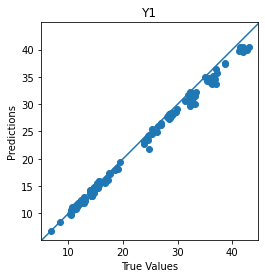

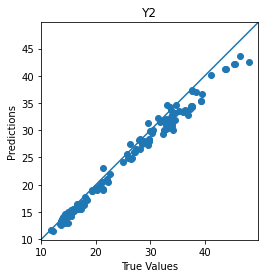

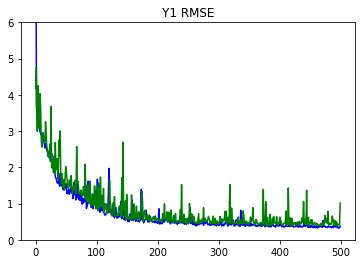

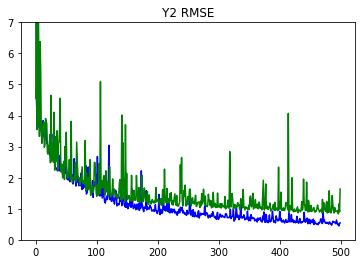

In [11]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)

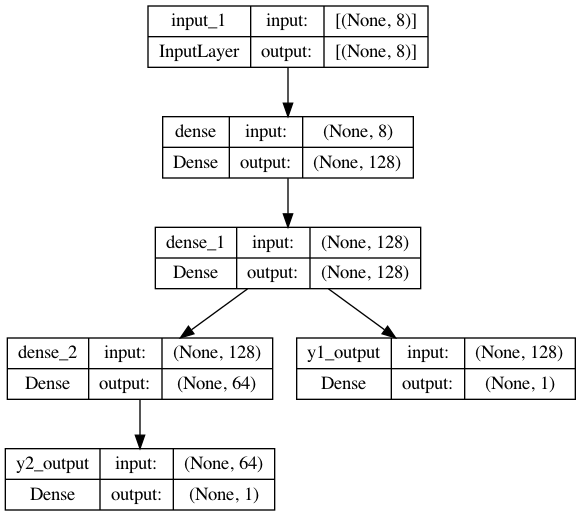

In [13]:
# Plot model graph
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model2.png')